In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Styling Notebook Output

# Adjust cell height
HTML("""
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:2000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>
""")

In [3]:
# Load the dataset for all car makes
def load_full_dataset():
    dataset_file = f'./data/UsedCarDataFULL.csv'
    df_full = pd.read_csv(dataset_file, usecols=['year', 'make', 'model', 'odometer', 'price'], low_memory=False)
    df_full['make'] = df_full['make'].str.lower()
    df_full['model'] = df_full['model'].str.lower()
    return df_full

# Initialize the UI and load the dataset
def init_ui_and_load_dataset(make):
    global df, X_train_scaled, y_train, X_test_scaled, y_test, rf, enc, scaler, imp
    df = get_data_by_make(make)

    dataset_file = f'./data/UsedCarData{make.upper()}.csv'
    df = pd.read_csv(dataset_file, usecols=['year', 'make', 'model', 'odometer', 'price'], low_memory=False)
    df['make'] = df['make'].str.lower()
    df['model'] = df['model'].str.lower()

    # Preprocessing and model training
    X = df[['year', 'make', 'model', 'odometer']]
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    enc = OneHotEncoder(handle_unknown='ignore')

    X_train_cat = enc.fit_transform(X_train[['make', 'model']])
    X_test_cat = enc.transform(X_test[['make', 'model']])

    scaler = MinMaxScaler()
    X_train_num = scaler.fit_transform(X_train[['year', 'odometer']])
    X_test_num = scaler.transform(X_test[['year', 'odometer']])

    imp = IterativeImputer(random_state=42)
    X_train_num_imp = imp.fit_transform(X_train_num)
    X_test_num_imp = imp.transform(X_test_num)

    X_train_scaled = np.hstack([X_train_num_imp, X_train_cat.toarray()])
    X_test_scaled = np.hstack([X_test_num_imp, X_test_cat.toarray()])

    model_path = f'./models/random_forest_{make}.pkl'

    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            rf = pickle.load(f)
    else:
        # Perform grid search to find the best hyperparameters
        from sklearn.model_selection import GridSearchCV

        param_grid = {
            'n_estimators': [10, 50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        rf = RandomForestRegressor(random_state=42)

        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train_scaled, y_train)

        best_params = grid_search.best_params_
        print(f"Best hyperparameters: {best_params}")

        rf = grid_search.best_estimator_

        # Save the best model to a file if it doesn't exist
        with open(model_path, 'wb') as f:
            pickle.dump(rf, f)

        
    # Update the drop-down menus for year and model
    year_widget.options = sorted(df['year'].unique())
    model_widget.options = sorted(df['model'].unique())

    # Update the training and test scores
    training_score.value = f"Training Score: {rf.score(X_train_scaled, y_train):.2f}"
    test_score.value = f"Test Score: {rf.score(X_test_scaled, y_test):.2f}"


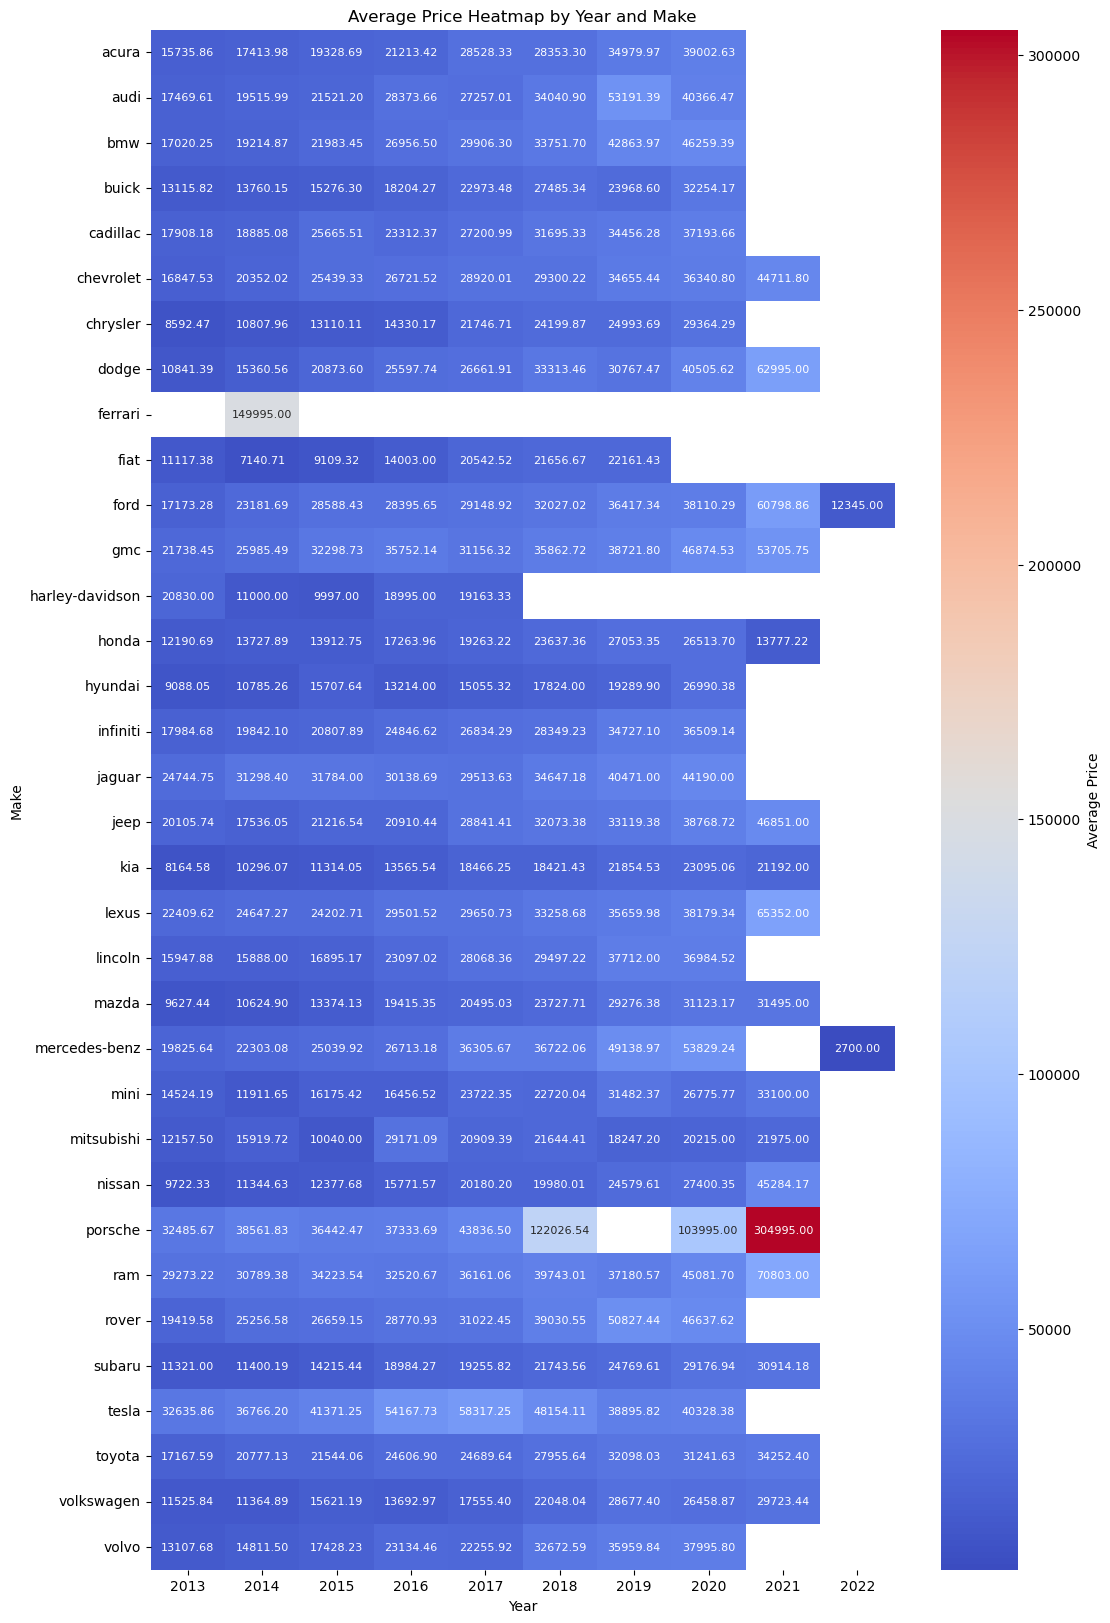

In [4]:
#Functions of Exploratory Data Analysis for All Makes Dataset and Display of all_make_graph1
df_full = load_full_dataset()

def all_make_plot(df):
    # Scatterplot of price vs odometer for all makes
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='odometer', y='price', hue='make', data=df, alpha=0.5)
    plt.title('Price vs Odometer for All Makes')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize='small')
    plt.show()


def all_make_bar(df):
    # Bar plot of average price per make
    avg_price_per_make = df.groupby('make')['price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_price_per_make.index, y=avg_price_per_make.values, palette='viridis')
    plt.title('Average Price per Make')
    plt.ylabel('Average Price')
    plt.xticks(rotation='vertical')  # Rotate the x-axis labels
    plt.show()
    
def all_make_histogram(df):
    # Histogram of price distribution for all makes
    plt.figure(figsize=(12, 6))
    ticks = np.linspace(0, 50000, 51) # Generate 51 evenly spaced ticks between 0 and 50,000
    bins = ticks - (ticks[1] - ticks[0])/2 # Shift the bins to center each bar on the tick
    sns.histplot(data=df, x='price', bins=bins, kde=True)
    plt.title('Price Distribution for All Makes')
    plt.xticks(ticks)
    plt.xticks(rotation='vertical')  # Rotate the x-axis labels
    plt.xlim(0, 50000)  # Set the x-axis range to ensure even spacing
    plt.show()

def plot_feature_importances(model, columns, make):
    feature_importances = pd.Series(model.feature_importances_, index=columns)
    feature_importances.nlargest(20).plot(kind='barh', figsize=(12, 8))  # Adjust the chart size to (12, 8)
    plt.title(f"Feature Importances for {make}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

def display_scatterplot(df, make=None):
    if make:
        df = df[df['make'] == make.lower()]

    sns.scatterplot(data=df, x='odometer', y='price', hue='make')
    plt.xlabel('Odometer (Miles)')
    plt.ylabel('Price ($)')
    if make:
        plt.title(f'Price vs. Odometer for {make}')
    else:
        plt.title('Price vs. Odometer for All Makes')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

    if make:  # Only display the feature importances chart when a make is selected
        columns = enc.get_feature_names_out(['make', 'model']).tolist() + ['year', 'odometer']
        plot_feature_importances(rf, columns, make)
        
def create_heatmap_no_model(df):
    # Data preprocessing for heatmap
    heatmap_df = df[['year', 'make', 'odometer', 'price']]
    heatmap_df = heatmap_df.groupby(['year', 'make']).agg({'odometer': 'mean', 'price': 'mean'}).reset_index()
    
    # Pivot the dataframe
    heatmap_pivot = heatmap_df.pivot_table(index='make', columns='year', values='price', aggfunc=np.mean)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 20))
    sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 8}, cbar_kws={'label': 'Average Price'})
    plt.title('Average Price Heatmap by Year and Make')
    plt.xlabel('Year')
    plt.ylabel('Make')
    plt.show()
    

# Display heatmap without model
create_heatmap_no_model(df_full)

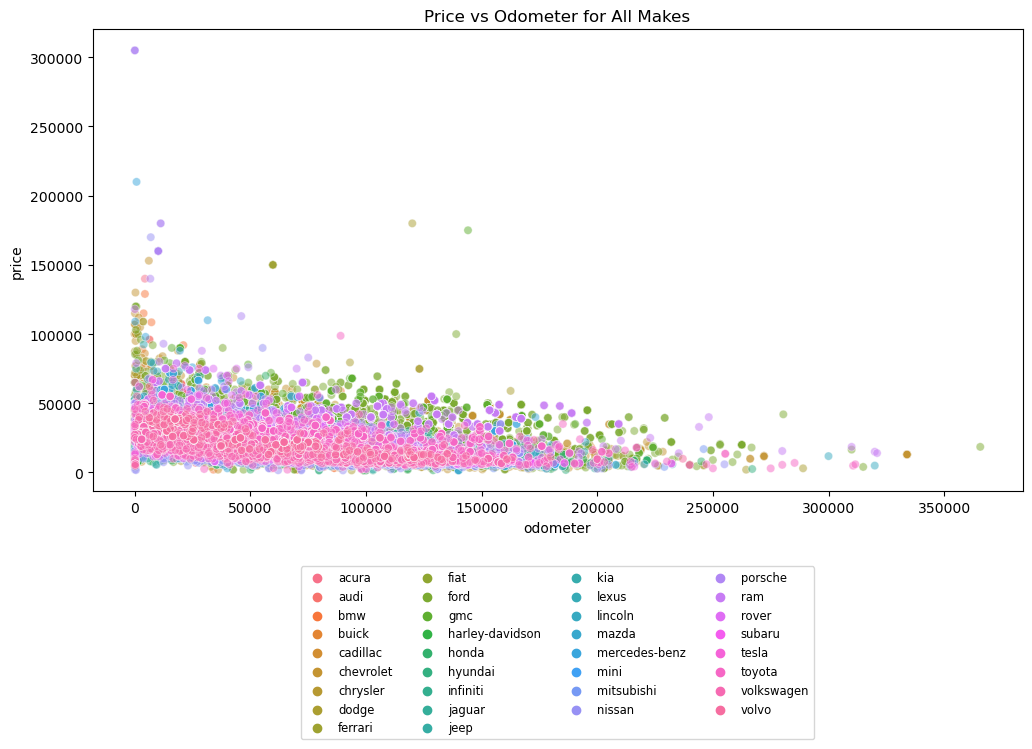

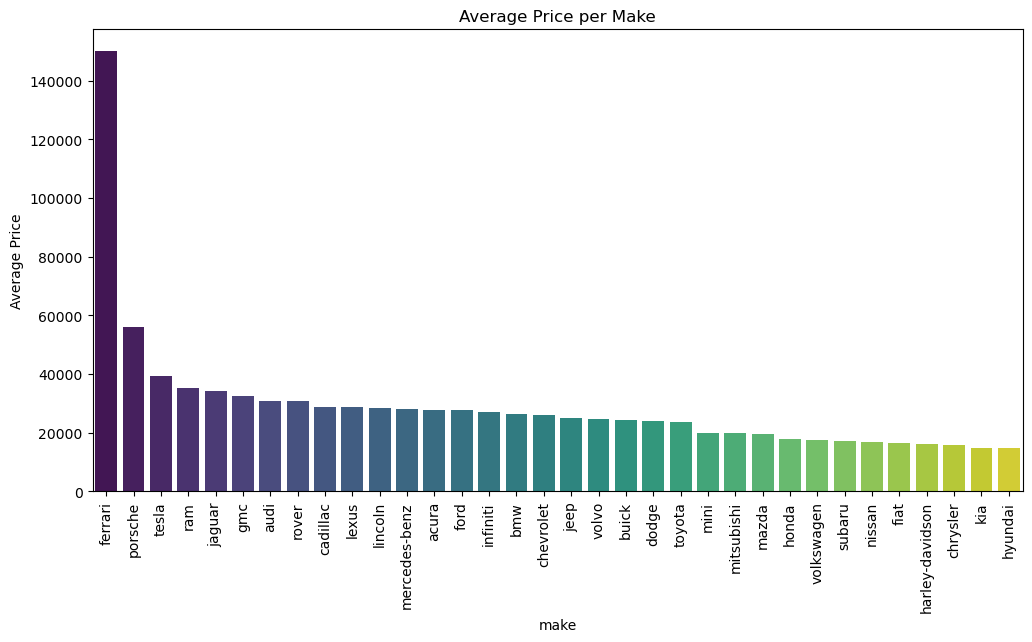

In [5]:
def predict_car_price(button):
    notification.value = "Please wait for the prediction..."
    selected_year = year_widget.value
    selected_make = make_widget.value
    selected_model = model_widget.value
    selected_odometer = odometer_widget.value

    user_input = pd.DataFrame([[selected_year, selected_make, selected_model, selected_odometer]],
                              columns=['year', 'make', 'model', 'odometer'])

    user_input_cat = enc.transform(user_input[['make', 'model']])
    user_input_num = scaler.transform(user_input[['year', 'odometer']])
    user_input_num_imp = imp.transform(user_input_num)
    user_input_scaled = np.hstack([user_input_num_imp, user_input_cat.toarray()])

    prediction = rf.predict(user_input_scaled)
    prediction_text.value = f"Estimated Price for {selected_year} {selected_make.capitalize()} {selected_model.capitalize()} with {selected_odometer:,} miles: ${prediction[0]:,.2f}"
    notification.value = ""

    # Update the price history
    if not price_history.children:
        price_history_label = widgets.HTML(value='<b style="font-size:1.2em;">History of Estimates:</b>')
        price_history.children += (price_history_label,)
    price_history.children += (widgets.Label(value=prediction_text.value),)

    # Update the scatterplot based on the selected make
    clear_output(wait=True)
    display(score_box, year_widget, make_widget, model_widget, odometer_widget, predict_button_and_status, price_history, notification)
    display_scatterplot(df_full, selected_make)

year_widget = widgets.Dropdown(description='Year:')
make_widget = widgets.Dropdown(description='Make:', options=sorted(['Acura','Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Fiat', 'Ford', 'GMC', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar', 'Jeep', 'Kia', 'Lexus', 'Lincoln', 'Mazda', 'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Porsche', 'RAM', 'Rover', 'Subaru', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']))
model_widget = widgets.Dropdown(description='Model:')
odometer_widget = widgets.IntSlider(description='Odometer:', min=10000, max=400000, step=1000)
predict_button = widgets.Button(description="Estimate Price")
predict_button.on_click(predict_car_price)
make_label = widgets.HTML(value="", layout=widgets.Layout(margin="0 0 10px 0"))
training_score = widgets.Label(value="")
test_score = widgets.Label(value="")
loading_status = widgets.HTML(value="", layout=widgets.Layout(margin="0 0 20px 0"))

# Score box
score_box = widgets.HBox([
    widgets.VBox([
        make_label
    ], layout=widgets.Layout(width='15%', height='50px')),
    widgets.VBox([
        training_score
    ], layout=widgets.Layout(width='15%', height='50px')),
    widgets.VBox([
        test_score
    ], layout=widgets.Layout(width='15%', height='50px')),
])

price_history = widgets.VBox([], layout=widgets.Layout(border='1px solid black', padding='10px', width='70%', background_color='#f0f0f0'))

# Display all_make_graph1
all_make_plot(df_full)

# Display all_make_graph2
all_make_bar(df_full)

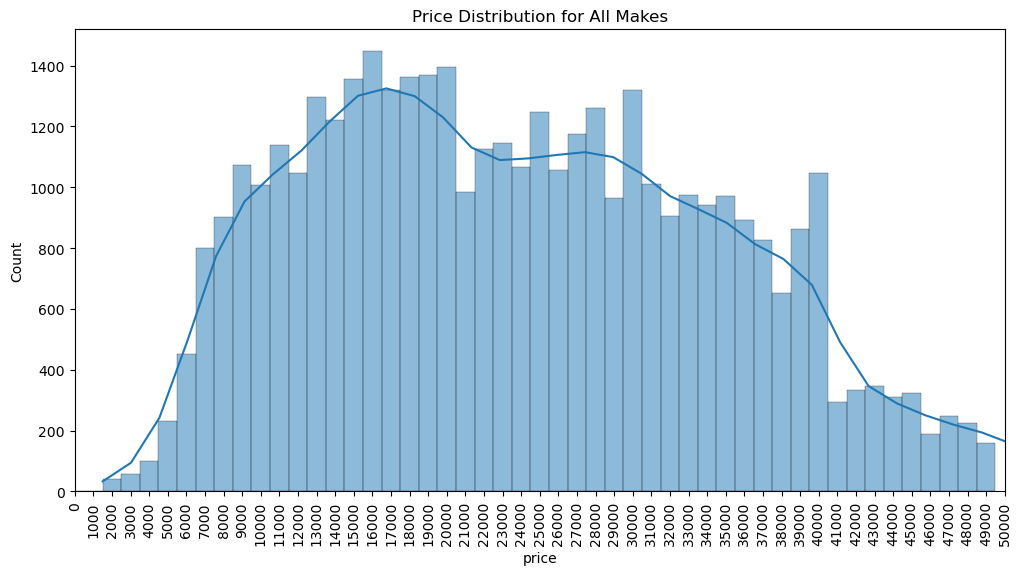

In [6]:
def update_models(change=None):
    if change is not None and change['type'] == 'change' and change['name'] == 'value':
        selected_year = change['new']
    else:
        selected_year = year_widget.value

    filtered_df = df[(df['year'] == selected_year) & (df['make'] == make_widget.value.lower())]
    model_widget.options = sorted(filtered_df['model'].unique())

year_widget.observe(update_models)

def set_widget_options(widget, options, value=None):
    with widget.hold_trait_notifications():
        widget.options = options
        if value is not None:
            widget.value = value
        elif widget.value not in options:
            widget.value = options[0] if options else None

def get_data_by_make(make):
    dataset_file = f'./data/UsedCarData{make.upper()}.csv'
    df = pd.read_csv(dataset_file, usecols=['year', 'make', 'model', 'odometer', 'price'], low_memory=False)
    return df

def update_odometer_range():
    selected_make = make_widget.value.lower()
    filtered_df = df[(df['make'] == selected_make) & (df['odometer'] <= 1_000_000)]
    
    if not filtered_df.empty:
        max_odometer = np.nanmax(filtered_df['odometer'].fillna(400000))
        max_odometer = int(max_odometer) if not np.isnan(max_odometer) else 400000
    else:
        max_odometer = 400000
        
    odometer_widget.max = max_odometer

def update_widgets(make):
    init_ui_and_load_dataset(make)
    make_label.value = f"<b>{make}: </b>"

    years = sorted(df['year'].unique())
    set_widget_options(year_widget, years, years[-1] if years else None)

    update_models()
    update_odometer_range()

def on_make_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        loading_status.value = f'<b style="font-size:1.2em;">Loading {change["new"]} data, please wait...</b>'
        update_widgets(change['new'])
        loading_status.value = ""

make_widget.observe(on_make_change)

# Display all_make_graph3
all_make_histogram(df_full)


Dropdown(description='Year:', index=7, options=(2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020), value=2020)

Dropdown(description='Make:', options=('Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', '…

Dropdown(description='Model:', options=('ilx', 'mdx', 'rdx', 'tlx'), value='ilx')

IntSlider(value=10000, description='Odometer:', max=180000, min=10000, step=1000)

VBox(layout=Layout(border='1px solid black', padding='10px', width='70%'))

Output()

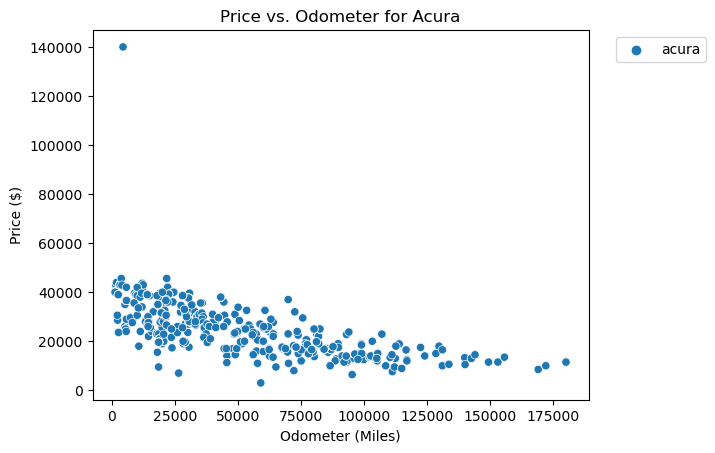

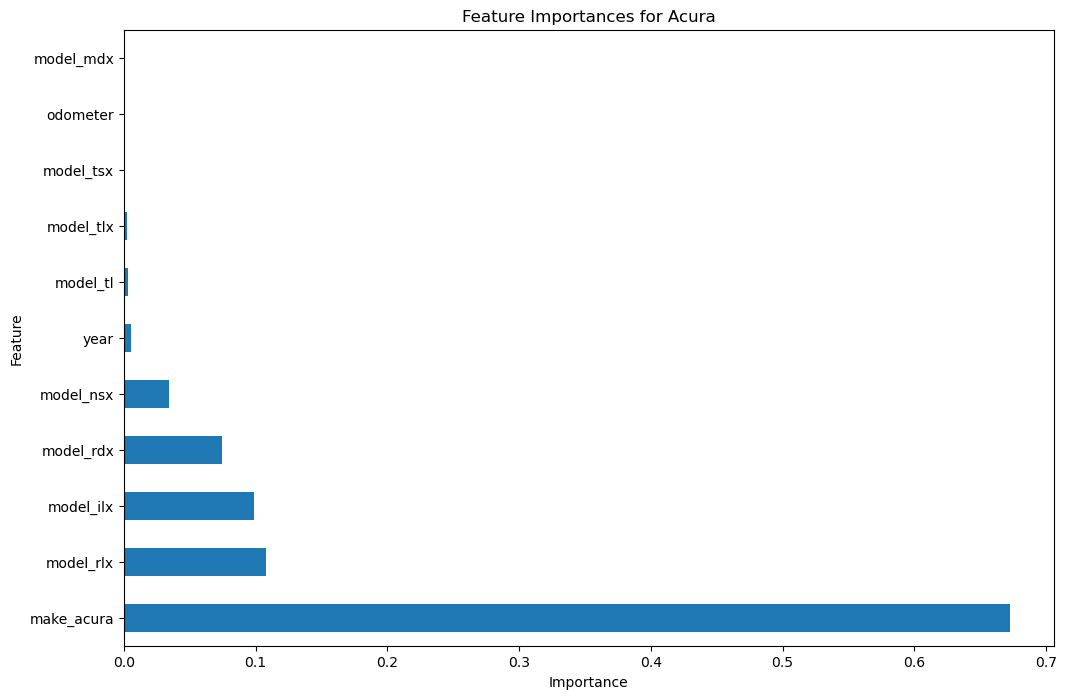

In [7]:
# Notification widget
notification = widgets.Output()
loading_status = widgets.HTML(value="")

prediction_text = widgets.Label(value="")
predict_button.on_click(predict_car_price)

# Create a VBox to hold the predict button and loading_status
predict_button_and_status = widgets.VBox([
    predict_button,
    loading_status
])

# Load the initial dataset and set up the UI
update_widgets('Acura')

# Display the widgets
display(score_box, year_widget, make_widget, model_widget, odometer_widget, predict_button_and_status, price_history, notification)

# Display the scatterplot of initial dataset
display_scatterplot(df, 'Acura')